In [8]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-6beefaca-14cf-40c0-5d08-cfa0e327d626)


In [9]:
import json
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [10]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json \
    -O /tmp/sarcasm.json

--2021-03-18 14:30:25--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/sarcasm.json
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.197.128, 74.125.142.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5643545 (5.4M) [application/json]
Saving to: ‘/tmp/sarcasm.json’

/tmp/sarcasm.json   100%[===================>]   5.38M  --.-KB/s    in 0.03s   

2021-03-18 14:30:25 (165 MB/s) - ‘/tmp/sarcasm.json’ saved [5643545/5643545]



In [11]:
vocab_size = 1000
embedding_dim = 16
max_length = 120
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"
training_size = 20000

with open("/tmp/sarcasm.json", 'r') as f:
    datastore = json.load(f)

sentences = []
labels = []
urls = []
for item in datastore:
    sentences.append(item['headline'])
    labels.append(item['is_sarcastic'])

training_sentences = np.array(sentences[0:training_size])
testing_sentences = np.array(sentences[training_size:])
training_labels = np.array(labels[0:training_size])
testing_labels = np.array(labels[training_size:])

In [12]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
tokenizer.fit_on_texts(training_sentences)
word_index = tokenizer.word_index

training_sequences = tokenizer.texts_to_sequences(training_sentences)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

testing_sequences = tokenizer.texts_to_sequences(testing_sentences)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

In [13]:
model = tf.keras.Sequential()

model.add( tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length))
model.add( tf.keras.layers.Conv1D(128, 5, activation='relu'))
model.add( tf.keras.layers.GlobalMaxPooling1D())
model.add( tf.keras.layers.Dense(24, activation='relu'))
model.add( tf.keras.layers.Dense(1, activation='sigmoid'))

model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 120, 16)           16000     
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 116, 128)          10368     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 24)                3096      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 25        
Total params: 29,489
Trainable params: 29,489
Non-trainable params: 0
_________________________________________________________________


In [14]:
history = model.fit(training_padded, training_labels, epochs = 30, validation_data = (testing_padded, testing_labels), verbose = 1)

Epoch 1/30
625/625 [==============================] - 4s 5ms/step - loss: 0.5620 - accuracy: 0.6901 - val_loss: 0.4157 - val_accuracy: 0.8123
Epoch 2/30
625/625 [==============================] - 3s 5ms/step - loss: 0.3558 - accuracy: 0.8406 - val_loss: 0.3942 - val_accuracy: 0.8225
Epoch 3/30
625/625 [==============================] - 3s 5ms/step - loss: 0.3170 - accuracy: 0.8592 - val_loss: 0.3944 - val_accuracy: 0.8225
Epoch 4/30
625/625 [==============================] - 3s 5ms/step - loss: 0.2776 - accuracy: 0.8794 - val_loss: 0.4106 - val_accuracy: 0.8150
Epoch 5/30
625/625 [==============================] - 3s 5ms/step - loss: 0.2467 - accuracy: 0.8971 - val_loss: 0.4273 - val_accuracy: 0.8165
Epoch 6/30
625/625 [==============================] - 3s 5ms/step - loss: 0.2149 - accuracy: 0.9147 - val_loss: 0.4590 - val_accuracy: 0.8071
Epoch 7/30
625/625 [==============================] - 3s 5ms/step - loss: 0.1785 - accuracy: 0.9318 - val_loss: 0.5109 - val_accuracy: 0.8038
Epoch 

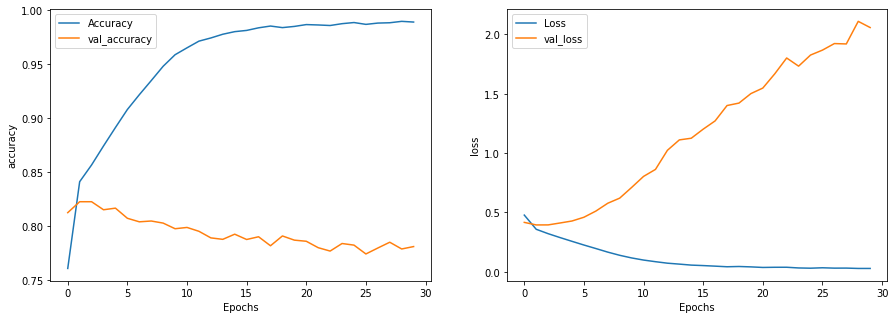

In [15]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.xlabel("Epochs")
plt.ylabel('accuracy')
plt.legend(['Accuracy', 'val_accuracy'])

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.xlabel("Epochs")
plt.ylabel('loss')
plt.legend(['Loss', 'val_loss'])
plt.show()